# *Real Python* - "SimPy: Simulating Real-World Processes With Python"

Joshua Cook

2020-04-07

This notebook is for my notes on the *Real Python* article on [SimPy](https://simpy.readthedocs.io/en/latest/): ["SimPy: Simulating Real-World Processes With Python"](https://realpython.com/simpy-simulating-with-python/).

![SimPy-Tutorial_Watermarked.75f57eed489c.jpg](assets/SimPy-Tutorial_Watermarked.75f57eed489c.jpg)

## How simulation works

There are three steps to running a simulation:

1. **Establish** the simulation environment.
2. **Pass** in the parameters.
3. **Run** the simulation.

## How to simulate with the `simpy` package

### The process the model

Our example will be focused around helping a movie theater reduce their wait times.
The *average wait time*, the time from the movie goer arrives to when their butt is in a seat.
The goal is to figure out the optimal number of employees to get this number below 10 minutes.

### Brainstorming the simulation algorithm

It is important to first think about how this process works in real life.
Here are the steps a movie goer might take:

1. Arrive at the theater, get in line, and wait to purchase a ticket.
2. Buy a ticket.
3. Wait in line to have the ticket checked.
4. Get the ticket checked by an usher.
5. Choose whether or not to get in line for the concession stand:
    - If they get in line, then they purchase food.
    - If they don't get in line, then they skip to the last step.
6. Go find their seat.

There are parts of this process that we can control (e.g. the number of cashiers at the box-office) and some that we can't (e.g. when people arrive).
For the processes that we cannot control, we have to pick parameters based the available data.

### Setting up the environment

We will first import the necessary libraries.

In [1]:
import simpy
import random
import statistics

We will also need a list to hold the wait times of the simulation.

In [2]:
wait_times = []

### Creating the environment: class definition

We will create a `Theater` class to be our environment.

In [3]:
class Theater(object):
    def __init__(self, env, num_cashiers, num_ushers, num_servers):
        self.env = env
        self.cashier = simpy.Resource(env, num_cashiers)
        self.usher = simpy.Resource(env, num_ushers)
        self.server = simpy.Resource(env, num_servers)
        
    
    def purchase_ticket(self, moviegoer):
        """Takes between 1 and 2 minutes to purchase a movie ticket."""
        yield self.env.timeout(random.randint(1, 3))
        
    def check_ticket(self, moviegoer):
        yield self.env.timeout(3.0/60.0)
    
    def sell_food(self, moviegoer):
        yield self.env.timeout(random.randint(1, 5))

### Moving through the environement: function definition

When a moviegoer arrives at the movies, they will request a resource, wait for the process the complete, then leave.
The function `go_to_movies()` will keep track of this.
Each movie goer buys a ticket and has the ticket checked.
They then have the option (modeled here as a 50/50 chance) to buy food.
There is a similar pattern for each resource *request*.

In [4]:
def go_to_movies(env, moviegoer, theater):
    # Arrive at the theatre.
    arrival_time = env.now
    
    # Purchase a ticket.
    with theater.cashier.request() as request:
        yield request
        yield env.process(theater.purchase_ticket(moviegoer))
    
    # Check the ticket.
    with theater.usher.request() as request:
        yield request
        yield env.process(theater.check_ticket(moviegoer))
    
    # Maybe get some food.
    if random.choice([True, False]):
        with theater.server.request() as request:
            yield request
            yield env.process(theater.sell_food(moviegoer))
    
    # Head into the theatre.
    wait_times.append(env.now - arrival_time)

### Making things happen: function definition

Finally, we can define a function to run the simulation, `run_theater()`.
It will create an instance of a theater and generate moviegoers until the simulation stops.

In this model, there will be three moviegoers waiting in line before the box office opens, and then new moviegoers will arrive every 12 seconds.

In [5]:
def run_theater(env, num_cashiers, num_servers, num_ushers):
    
    # Create the theater.
    theater = Theater(env, num_cashiers, num_servers, num_ushers)
    
    # Three moviegoers waiting in line before the box office opens.
    for moviegoer in range(3):
        env.process(go_to_movies(env, moviegoer, theater))
    
    while True:
        # Customers arrive every 12 sec, on average.
        yield env.timeout(12.0 / 60.0)
        
        moviegoer += 1
        env.process(go_to_movies(env, moviegoer, theater))

### Calculating the wait time: function definition

Now we need to calculate the average time a moviegoer spends from the time they arrive to the time they sit down for their movie.

In [6]:
def get_average_wait_time(wait_times):
    return statistics.mean(wait_times)

We also can make a function for printing the average wait time in a more reader-friendly way.

In [7]:
def calculate_wait_time(wait_times):
    average_wait = get_average_wait_time(wait_times)
    minutes, frac_minutes = divmod(average_wait, 1)
    seconds = frac_minutes * 60
    return round(minutes), round(seconds)

### Choosing parameters: user input function definition

This simulation has the following parameters: `num_cashiers`, `num_servers`, and `num_ushers`.
The `get_user_input()` function helps us get values for these parameters from the user.

In [8]:
def get_user_input():
    num_cashiers = input("# of cashiers: ")
    num_servers = input("# of servers: ")
    num_ushers = input("# of ushers: ")
    
    params = [num_cashiers, num_servers, num_ushers]
    if all(str(i).isdigit() for i in params):
        params = [int(x) for x in params]
    else: 
        print(
            "Could not parse input. The simulation will use default values:",
            "\n1 cashier, 1 server, 1 usher."
        )
        params = [1, 1, 1]
    return params

### Finalizing the setup: main function definition

We just need to create a main function that will ensure the functions written above are executed in the correct order.

In [9]:
def main():
    # Setup.
    random.seed(0)
    num_cashiers, num_servers, num_ushers = get_user_input()
    
    # Run the simulation.
    print("Running simulation...")
    env = simpy.Environment()
    env.process(run_theater(env, num_cashiers, num_servers, num_ushers))
    env.run(until=90)
    
    # View the results.
    mins, secs = calculate_wait_time(wait_times)
    print(f"The average wait time is {mins} min. and {secs} sec.")

We can now call the `main()` function to run a simulation.

In [10]:
main()

# of cashiers: 10
# of servers: 10
# of ushers: 5
Running simulation...
The average wait time is 8 min. and 17 sec.


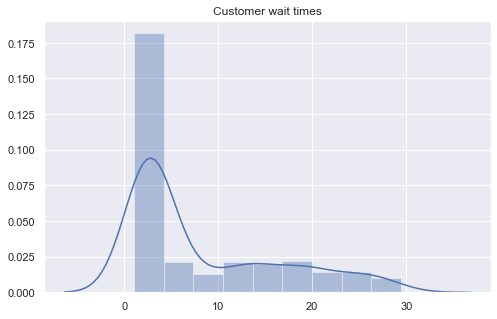

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)

fig = plt.figure(figsize=(8, 5))
sns.distplot(wait_times)
plt.title("Customer wait times")
plt.show()